In [1]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)  

2024-10-14 13:04:27.534061: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 13:04:28.049841: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
pc1_l = all_df['PC1'].min()
pc1_u = all_df['PC1'].max()
pc2_l = all_df['PC2'].min()
pc2_u = all_df['PC2'].max()

pc1_grid = np.linspace(pc1_l, pc1_u, 75)
pc2_grid = np.linspace(pc2_l, pc2_u, 75)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']]) 

In [3]:
import kmedoids
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
diss = euclidean_distances(all_maps_interp_flat)

In [23]:
kmin = 10

In [24]:
# Lets try running k-medoid 100 times and see how consistent the results are
md_list = []
for i in tqdm(range(1)):
    md = kmedoids.fasterpam(diss, kmin, max_iter=100, init='random', random_state=None, n_cpu=-1)
    md_list.append(md)

  0%|          | 0/1 [00:00<?, ?it/s]

In [25]:
mds_pca_list = []
mds_maps_list = []
for mds in md_list:
    medoids_idx = mds.medoids
    medoids_maps = all_maps_interp_flat[medoids_idx]
    medoids_pca = pca.transform(medoids_maps)
    mds_pca_list.append(medoids_pca)
    mds_maps_list.append(medoids_maps)

In [26]:
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

In [32]:
cluster_labels = mds.labels
cluster_labels = pd.Series(cluster_labels)
cluster_size = cluster_labels.value_counts()

In [44]:
cluster_size.sort_index().values

array([333, 402, 365, 267,  23, 292, 363, 356, 212, 369])

In [43]:
all_medoids_df = pd.DataFrame() 
for i, mds_pca in enumerate(mds_pca_list):
    medoids_df = pd.DataFrame(mds_pca, columns=['PC1', 'PC2'])
    medoids_df['label'] = 'medoid_' + str(i)
    medoids_df['size'] = cluster_size.sort_index().values
    # all_df = pd.concat([all_df, medoids_df], axis=0)
    all_medoids_df = pd.concat([all_medoids_df, medoids_df], axis=0)

<Axes: xlabel='PC1', ylabel='PC2'>

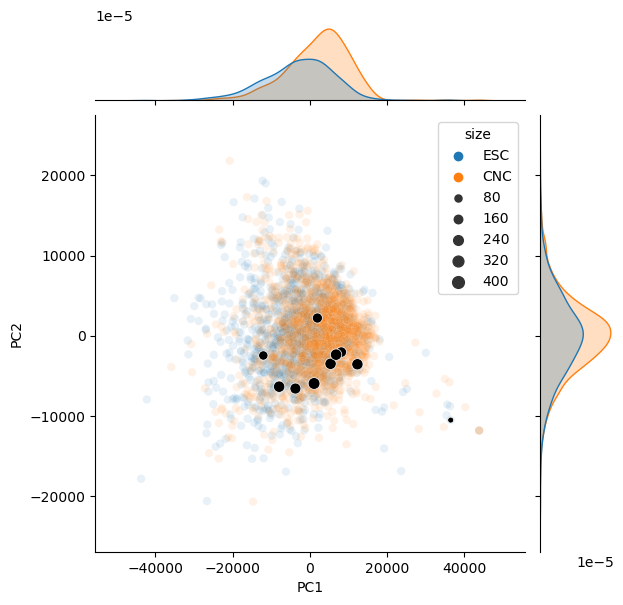

In [45]:
sns.jointplot(data=all_df, x='PC1', y='PC2', hue='label', kind='scatter', alpha=0.1, palette='tab10')
sns.scatterplot(data=all_medoids_df, x='PC1', y='PC2', size='size', color='black')

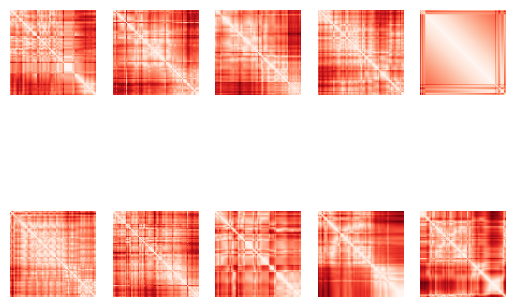

In [29]:
for x in mds_maps_list:
    # Plot the heatmap of all medoids
    fig, ax = plt.subplots(2, kmin//2)
    for i in range(2):
        for j in range(kmin//2):
            ax[i, j].imshow(x[i*kmin//2+j].reshape(80, 80), cmap='Reds')
            ax[i, j].axis('off')

In [30]:
# Find the number of members in each cluster
cluster_labels = mds.labels
cluster_labels = pd.Series(cluster_labels)
cluster_labels.value_counts()

1    402
9    369
2    365
6    363
7    356
0    333
5    292
3    267
8    212
4     23
Name: count, dtype: int64

In [31]:
cluster_labels.value_counts()[0]

333